# Modelo de Red Neuronal

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

# Cargue de Librerías

In [ ]:
!pip install unidecode
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 13.3 MB/s eta 0:00:00


In [ ]:
# Importación librerías
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Carga de la base de datos

In [ ]:
dt= pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0).reset_index().drop("index",axis=1)

# Visualización de la base de datos

In [ ]:
dt.head()

,year,title,plot,genres,rating
0,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


## Tamaño de la  base de datos

In [ ]:
dt.shape

(7895, 5)

Se descartan las variables que no aportan al proyecto

In [ ]:
dt=dt[["plot","genres"]]
dt.head()

,plot,genres
0,most is the story of a single father who takes...,"['Short', 'Drama']"
1,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']"
2,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']"
3,"in a friday afternoon in new york , the presi...",['Drama']
4,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']"


# Tipos de variables

In [ ]:
dt.dtypes

plot      object
genres    object
dtype: object

# Peso de la base de datos

In [ ]:
import sys
print("La base de datos tiene un peso de ",sys.getsizeof(dt)," bytes")

La base de datos tiene un peso de  7045029  bytes


# Cantidad de filas vacias en la base de datos

In [ ]:
dt.isnull().sum()

plot      0
genres    0
dtype: int64

## Preprocesamiento

In [ ]:
def preprocess(text,min_len=2, max_len=23):
    pat = re.compile(r"[^a-z ]")
    spaces = re.compile(r"\s{2,}")

    # Normalizamos el texto
    norm_text = unidecode(text)
    doc = nlp(norm_text)

    # Eliminamos stopwords
    filtered_tokens = filter(lambda token: not token.is_stop, doc )

    # Filtramos palabras por longitud
    filtered_tokens2 = filter(lambda token: len(token) >= min_len
                              and len(token) <= max_len, filtered_tokens)

    # Obtenemos los lemmas de cada token
    lemmas = map(lambda token: token.lemma_, filtered_tokens2 )
    stem = map( lambda token: snow_stemmer.stem(token), lemmas )
    lemma_text = " ".join(stem)

    # Quitamos grafía
    lower_text = lemma_text.lower()

    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, "", lower_text)

    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    return spaces_text.strip()
prepo_text=list(nlp.pipe(dt["plot"].apply(preprocess).tolist(), n_process=-1))

In [ ]:
dt['preprocessed_plot'] = [doc.text for doc in prepo_text]

#  Preprocesamiento Variable objetivo

In [ ]:
dt["genres"] = dt["genres"].apply(lambda x: x.replace('[','').replace(']','').replace("\'",''))
dt.head()

,plot,genres,preprocessed_plot
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...


In [ ]:
genres_df = dt['genres'].str.get_dummies(sep=', ')
data = dt.drop(['genres','preprocessed_plot'], axis=1)
data = pd.concat([dt, genres_df], axis=1)
data.head()

,plot,genres,preprocessed_plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Embedding de la variable plot con limpieza de tokens

In [ ]:
vect = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=0.03).fit(dt.preprocessed_plot)
display(vect)

features = vect.transform(dt.preprocessed_plot).toarray()
display(features.shape)


TfidfVectorizer(max_df=0.95, min_df=0.03, sublinear_tf=True)

(7895, 280)

In [ ]:
emb=[]
target=[]
for i in range(data.shape[0]):
  for j in data.genres[i].split(', '):
    if j!="News":
      emb.append(features[i])
      target.append(j)
emb=np.array(emb)
target=np.array(target)

# Generación de pesos de las clases según su frecuencia

In [ ]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(target),
    y=target)
dict(zip(np.unique(target),classes_weights))

{'Action': 0.7197103673796256,
 'Adventure': 0.9158033288043478,
 'Animation': 3.60685618729097,
 'Biography': 2.5141624898006762,
 'Comedy': 0.3078734762625253,
 'Crime': 0.6480874973708722,
 'Documentary': 2.2381446508249456,
 'Drama': 0.23651515982235868,
 'Family': 1.3750478133367334,
 'Fantasy': 1.3264251891027612,
 'Film-Noir': 5.58203933747412,
 'History': 3.4351011307533046,
 'Horror': 0.983000638045757,
 'Music': 2.750095626673467,
 'Musical': 3.4604524306112627,
 'Mystery': 1.2355502090851807,
 'Romance': 0.4956567699237062,
 'Sci-Fi': 1.2970713813217873,
 'Short': 10.193289224952741,
 'Sport': 3.5930368149258705,
 'Thriller': 0.4633313284069428,
 'War': 2.694777611194403,
 'Western': 3.9568886442854523}

In [ ]:
target=pd.get_dummies(target)
gen=target.columns
target=target.to_numpy()

# Separación en Base de datos en Entrenamiento, Validación y de Testeo

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split( emb, target, test_size=0.15, random_state=42,stratify=target)
X_train, X_test, y_train, y_test = train_test_split( features, genres_df.drop(["News"],axis=1).to_numpy(), test_size=0.15, random_state=42)#,stratify=genres_df.drop(["News"],axis=1).to_numpy())

In [ ]:
#X_Train, X_val, y_Train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42,stratify=y_train)
X_Train, X_val, y_Train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)#,stratify=y_train)

In [ ]:
print(y_Train.shape,y_val.shape,y_test.shape)

(5703, 23) (1007, 23) (1185, 23)


In [ ]:
print(X_Train.shape,X_val.shape,X_test.shape)

(5703, 280) (1007, 280) (1185, 280)


# Configuración y cargue de librerías de Deep Learning

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from keras_tuner import HyperModel, RandomSearch
import keras_tuner

In [ ]:
batch_size=X_Train.shape[0]//64
train_dataset =tf.data.Dataset.from_tensor_slices((X_Train, y_Train)).shuffle(len(X_Train))
train_dataset = train_dataset.shuffle(len(X_Train)).batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

# Definición de función de perdida acorde a un problema de clasificación desbalanceado

In [ ]:
class WeightedCrossEntropy(tf.keras.losses.Loss):
  def __init__(self, weight, epsilon=1e-7, name="weighted_cross_entropy", **kwargs):
    super().__init__(name=name, **kwargs)
    self.weight = weight
    self.epsilon = epsilon

  def call(self, y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, self.epsilon, 1 - self.epsilon)
    y_true=tf.cast(y_true, tf.float32)
    loss = -(self.weight * y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.math.reduce_mean(loss)

  def get_config(self):
    config = {
      'weight': self.weight,
      'epsilon': self.epsilon
      }
    base_config = super().get_config()
    return {**base_config, **config}

# Arquitectura de la red neuronal

In [ ]:
loss_fn = WeightedCrossEntropy(weight=classes_weights)

def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=128, max_value=512, step=8),
                    activation=hp.Choice('activation', values=['relu']), input_shape=(None,X_Train.shape[1])))
    model.add(Dropout(hp.Choice('drop1', values=[0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])))
    #model.add(Dense(units=hp.Int('units2', min_value=1, max_value=256, step=16),activation='relu'))
    #model.add(Dropout(hp.Choice('drop2', values=[0.1,0.2,0.3,0.4,0.5,0.6])))
    model.add(Dense(23, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=loss_fn,
                  metrics=["accuracy"])
    return model

In [ ]:
nn = build_model(keras_tuner.HyperParameters())
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 128)         35968     
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_5 (Dense)             (None, None, 23)          2967      
                                                                 
Total params: 38,935
Trainable params: 38,935
Non-trainable params: 0
_________________________________________________________________


# Búsqueda de hiperparámetros con Keras Tuner

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="",
    project_name="movie",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 8, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
drop1 (Choice)
{'default': 0.05, 'conditions': [], 'values': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(train_dataset, epochs=200,validation_data=val_dataset,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="min")])

Trial 3 Complete [00h 00m 15s]
val_accuracy: 0.28345251083374023

Best val_accuracy So Far: 0.28345251083374023
Total elapsed time: 00h 00m 33s


# Mejores hiperparámetros

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_hps.values

{'units1': 328, 'activation': 'relu', 'drop1': 0.3, 'learning_rate': 0.001}

# Entrenamiento de modelo con los mejores hiperparámetros

In [ ]:
cnn = build_model(best_hps)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, None, 328)         92168     
                                                                 
 dropout_1 (Dropout)         (None, None, 328)         0         
                                                                 
 dense_3 (Dense)             (None, None, 23)          7567      
                                                                 
Total params: 99,735
Trainable params: 99,735
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',            # La métrica que se va a monitorear.
                patience=5,              # Si después de 50 epochs la métrica no mejora, se detiene el entrenamiento.
                mode="min",               # Se quiere guardar el modelo que reporte el accuracy máximo: max.
                restore_best_weights=True # Si True, automaticamente se cargan al modelo los mejores pesos.
            )
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                  filepath='best_weights.h5', # Path del archivo donde se guardarán los pesos o el modelo.
                  monitor='val_accuracy',              # La métrica que se va a monitorear.
                  mode="max",                 # Se quiere guardar el modelo que reporte el accuracy máximo: max.
                  save_best_only=True,        # Si se define True, entonces solo se guarda el mejor modelo.
                  save_weights_only=False      # Si se define True, solo se guardan los pesos, no la arquitectura.
              )
hist = cnn.fit(train_dataset, epochs=200,
                 batch_size=batch_size,
                validation_data=val_dataset,
                 callbacks=[checkpoint, stopping])

Epoch 1/200
64/64 [==============================] - 1s 5ms/step - loss: 0.4776 - accuracy: 0.1127 - val_loss: 0.3555 - val_accuracy: 0.2094
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 0.3561 - accuracy: 0.2082 - val_loss: 0.3431 - val_accuracy: 0.2227
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 0.3396 - accuracy: 0.2268 - val_loss: 0.3276 - val_accuracy: 0.2411
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 0.3175 - accuracy: 0.2507 - val_loss: 0.3096 - val_accuracy: 0.2513
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 0.2967 - accuracy: 0.2635 - val_loss: 0.2967 - val_accuracy: 0.2635
Epoch 6/200
64/64 [==============================] - 0s 4ms/step - loss: 0.2820 - accuracy: 0.2621 - val_loss: 0.2877 - val_accuracy: 0.2533
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2710 - accuracy: 0.2547 - val_loss: 0.2837 - val_accuracy: 0.2349
Epoch 8/200
6

# Evaluación de la función de perdida y el accuracy

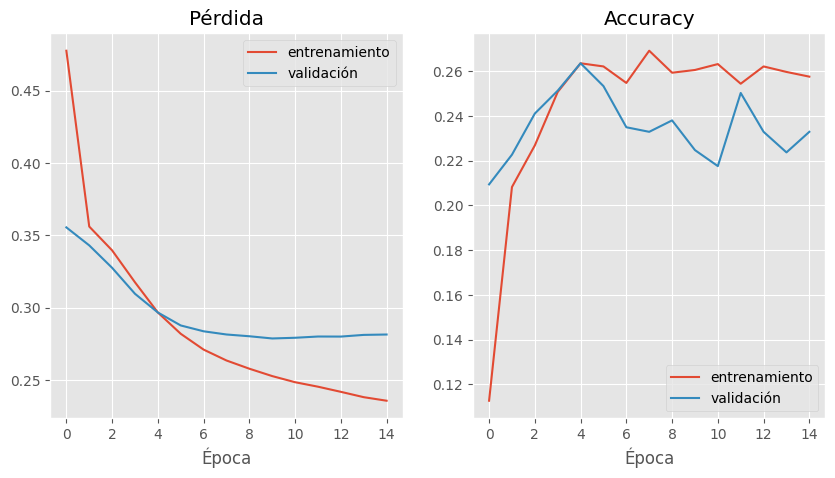

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(hist.history["loss"], label="entrenamiento")
plt.plot(hist.history["val_loss"], label="validación")
plt.title("Pérdida"); plt.xlabel("Época"); plt.legend()
plt.subplot(122)
plt.plot(hist.history["accuracy"], label="entrenamiento")
plt.plot(hist.history["val_accuracy"], label="validación")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()

# Evaluación ROC AUC

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, cnn.predict(X_test), average="macro",multi_class='ovr')

38/38 [==============================] - 0s 2ms/step


0.8062781544975975

# Reporte de Clasificación

In [ ]:
from sklearn.metrics import classification_report
predictions = cnn.predict(X_test)
generos=['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
print(classification_report(y_test,(predictions > 0.5),target_names=generos))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      Action       0.67      0.15      0.25       198
   Adventure       0.76      0.13      0.23       164
   Animation       0.37      0.14      0.21        49
   Biography       0.45      0.07      0.13        68
      Comedy       0.71      0.03      0.05       459
       Crime       0.71      0.30      0.42       212
 Documentary       0.36      0.29      0.32        55
       Drama       0.83      0.08      0.15       584
      Family       0.53      0.13      0.21       124
     Fantasy       0.56      0.08      0.14       110
   Film-Noir       0.25      0.06      0.09        35
     History       0.28      0.19      0.23        36
      Horror       0.63      0.21      0.31       130
       Music       0.22      0.03      0.05        64
     Musical       0.17      0.03      0.04        39
     Mystery       0.49      0.18      0.26       105
     Romance       0.77     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
